# Graph kernels with PASQAL processor

In [1]:
import numpy as np
from utils import (
    return_list_of_states,
    return_energy_distribution,
    return_js_square_matrix,
)
from qutip import sigmaz, sigmap, qeye, tensor, sigmam
from data_preprocessing import load_dataset
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from skopt import gp_minimize

## Import the IMDB-MULTI dataset

We import the IMDB-MULTI dataset, limited to the graphs below 12 nodes. For the rest of the demo, we will limit ourselves to a sample of 150 graphs

Number of graphs:  1001


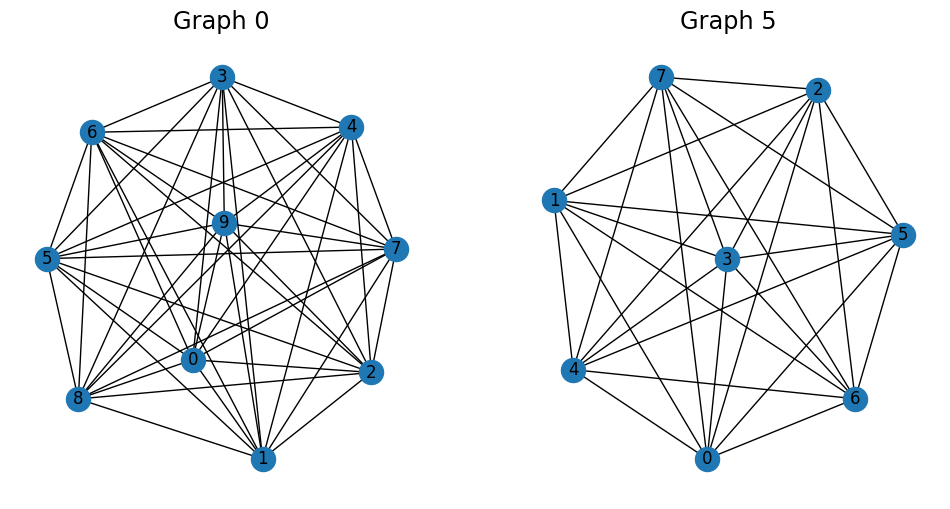

In [2]:
graphs, targets = load_dataset('IMDB-MULTI', min_node=0, max_node=12)
print("Number of graphs: ", len(graphs))

np.random.seed(40)
N_sample = 150
sample = np.random.choice(len(graphs), size=N_sample, replace=False).astype(int)

graphs_sample, targets_sample = graphs[sample], targets[sample]
graphs_sample = [nx.convert_node_labels_to_integers(G) for G in graphs_sample]
graphs_sample = np.array(graphs_sample, dtype=object)

plt.figure(figsize=[12,6])
plt.subplot(121)
nx.draw(graphs_sample[0], with_labels=True)
plt.title("Graph 0", fontsize='xx-large')
plt.subplot(122)
nx.draw(graphs_sample[5], with_labels=True)
plt.title("Graph 5", fontsize='xx-large')
plt.show()

In [3]:
print(len(graphs_sample))

150


## Generate the hamiltonian evolutions

We describe here how to perform a graph classification for specific values of times and pulses for a 2 layers ising evolution.

Generate the final states of all graphs 

In [4]:
# in this first stage, we build evolution and mixing Hamiltonians
# evolving the quantum state using an operator that encodes the topology of the graph should produce samples that retain key features of the graph
# we have chosen an Ising Hamiltonian to encode the topology of the graph into an operator form
# the mixing Hamiltonian ensures we explore the full solution space by allowing transitions between different states etc
# we use two layers of each of the above for our free evolution
# the resulting state encodes information about the graph structure and the problem solution space
# later, we might want to consider tuning the structure of problem and mixing Hamiltonians, number of layers etc

times = [2.1, 1.6]
pulses = [0.2, 0.1]

states = return_list_of_states(graphs_sample, times, pulses, evol='ising')

Plot some final states after evolution

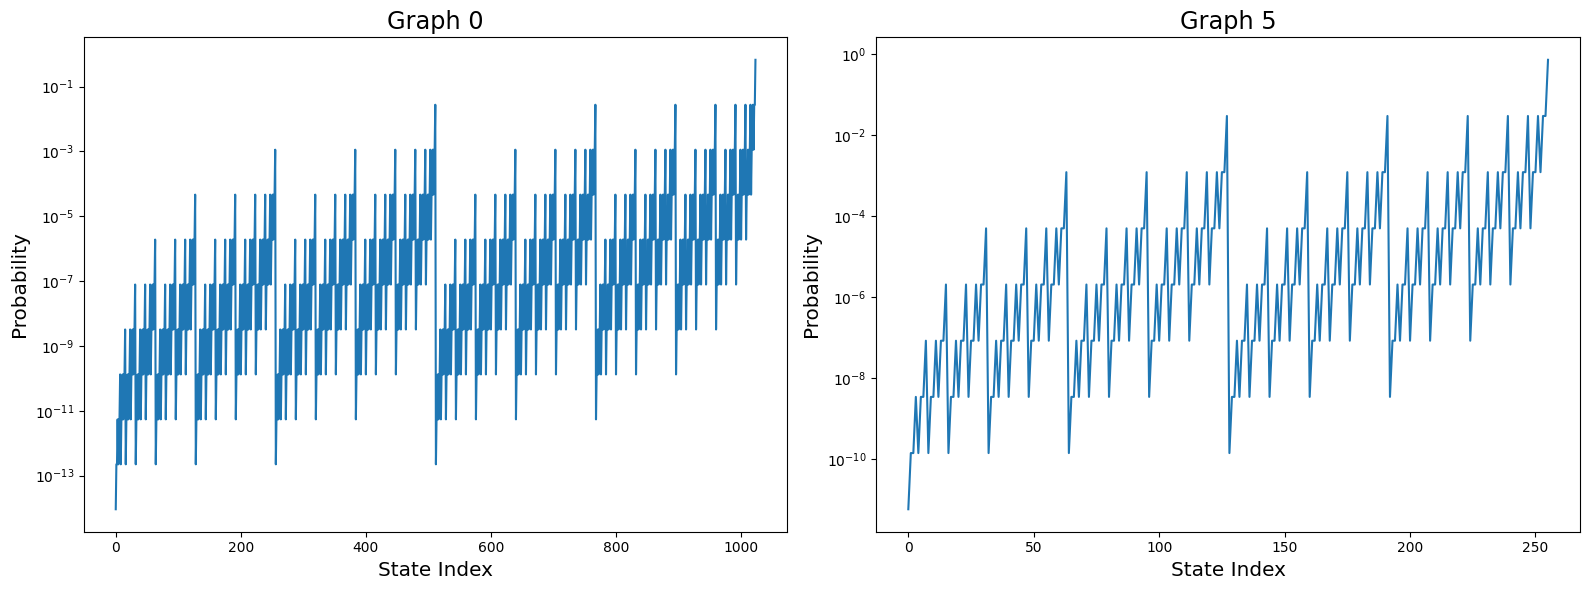

In [5]:
states_data = [
    np.abs(state.data) ** 2 for state in states
]

plt.figure(figsize=[16, 6])
plt.subplot(121)
plt.plot(states_data[0], label="Graph 0")
plt.yscale("log")
plt.xlabel("State Index", fontsize="x-large")
plt.ylabel("Probability", fontsize="x-large")
plt.title("Graph 0", fontsize="xx-large")
if len(states_data) > 5:
    plt.subplot(122)
    plt.plot(states_data[5], label="Graph 5")
    plt.yscale("log")
    plt.xlabel("State Index", fontsize="x-large")
    plt.ylabel("Probability", fontsize="x-large")
    plt.title("Graph 5", fontsize="xx-large")
plt.tight_layout()
plt.show()

Compute the probability distribution of the Ising observable from each state. First we compute the observables of each graph separately and we store them in a dictionary.

In [6]:
# now, for each graph, we will generate a diagonal observable to apply our quantum states
# this is so later, we can take measurements and extract a probability distribution over the eigenvalues of our observable
# this hamiltonian is naturally similar to our graph evolution hamiltonian above, but is constructed separately
# the function below returns our diagonal observable - in our case we have chosen Ising energies to be our observable
# generally, the Ising Hamiltonian is diagonal in the computational basis - so our basis coincides with the computational basis
# this means our Ising energy eigenvalues of observable O is the diagonal elements of the Hamiltonian we construct
# eigenvalues represent possible outcomes of applying observable O to our quantum states
# probabilities depend on the overlap between the quantum state and the eigenstates of O

def observable(graph):
    N = graph.number_of_nodes()

    si = qeye(2)
    sp = sigmap()
    sm = sigmam()

    sz = sigmaz()

    sp_list = []
    sz_list = []
    sm_list = []
    sn_list = []

    for j in range(N):
        op_list = [si for _ in range(N)]

        op_list[j] = sp
        sp_list.append(tensor(op_list))

        op_list[j] = sm
        sm_list.append(tensor(op_list))

        op_list[j] = sz
        sz_list.append(tensor(op_list))

        op_list[j] = 0.5 * (sz + si)
        sn_list.append(tensor(op_list))

    # construct the hamiltonian
    H = 0

    for node in graph.nodes.data():
        # node_weight = graph.degree[node[0]]
        node_weight = 0
        H += node_weight * sz_list[node[0]]

    for edge in graph.edges.data():
        edge_weight = 1
        H += edge_weight * sz_list[edge[0]] * sz_list[edge[1]]

    return H


from utils import Memoizer
observables_memoizer = Memoizer(observable)

Compute the probability distribution and the distance matrix

In [8]:
# below, we apply our diagonal observable function from above to each of our quantum states
# the diagonal elements (energies or eigenvalues) are extracted, which represent all possible measurement outcomes of O
# probabilities are then computed for each (unique) eigenvalue
# probabilities for each eigenvalue is summed to create discrete probability distributions for O
energies = return_energy_distribution(graphs_sample, states, observables_memoizer.get_observable)
# calculate distance between probabilty distributions using Jensen-Shannon divergence
matrix = return_js_square_matrix(energies)

In [9]:
def print_shape(result):
    if isinstance(result, tuple):
        print("Result is a tuple:")
        for idx, arr in enumerate(result):
            print(f"Shape of element {idx}: {arr.shape}")
    else:
        print("Result is a single array:")
        print(f"Shape: {result.shape}")

# for each graph (150), there is a single pd defined over 54 possible eigenvalues (Ising energies) of the observable
print_shape(energies)

Result is a single array:
Shape: (150, 54)


Fit the model

In [10]:
# distance between pds (J-S divergence) is used to build kernel
# kernel associated with SVM will produce an accuracy score based on performance of the test data
# we do a grid search for the hyperparameter C – where our C value is chosen based on whichever returns the best score for the test data
# idea is class of a new graph is then predicted by computing the similarity wrt graphs in the training dataset

K = np.exp(-matrix)
C_list = np.logspace(-3, 3, 7)

param_grid = {'C': C_list}
scoring = {'accuracy': make_scorer(accuracy_score),
            'f1_score': make_scorer(f1_score, average='weighted')
            }

skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=47)

estimator = svm.SVC(kernel='precomputed', random_state=76)

grid_search = GridSearchCV(estimator, param_grid, scoring=scoring,
                                cv=skf, refit=False, n_jobs=-1)
result = grid_search.fit(K, targets_sample).cv_results_

i_best = np.argmax(result['mean_test_accuracy'])
print('Accuracy: ', result['mean_test_accuracy'][i_best], '±', result['std_test_accuracy'][i_best])

Accuracy:  0.44866666666666677 ± 0.13461220020653566


## Find the best parameters

Now we look for the values of times and pulses to get the best accuracy score. This is done by bayesian optimization.

Define the score function

In [11]:
# now get cost value for each set of params
# try each set of times and pulses to see which ones get you the highest mean_test_accuracy

def get_score(param):
    middle = len(param)//2
    states = return_list_of_states(graphs_sample, param[0:middle], param[middle::], evol='ising')
    energies = return_energy_distribution(graphs_sample, states, observables_memoizer.get_observable)
    matrix = return_js_square_matrix(energies)
    K = np.exp(-matrix)
    C_list = np.logspace(-3, 3, 7)

    param_grid = {'C': C_list}
    scoring = {'accuracy': make_scorer(accuracy_score),
                'f1_score': make_scorer(f1_score, average='weighted')
                }

    skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=47)

    estimator = svm.SVC(kernel='precomputed', random_state=76)

    grid_search = GridSearchCV(estimator, param_grid, scoring=scoring,
                                    cv=skf, refit=False, n_jobs=-1)
    result = grid_search.fit(K, targets_sample).cv_results_

    return -np.max(result['mean_test_accuracy'])

Run the bayesian optimization (can take up to 15 min)

In [12]:
# params are now trained by Bayesian optimisation - cost function to optimise is an accuracy score averaged on all cross-validation splits

bounds = [(0., 3.)] * 2 + [(0., 1.)] * 2

opt_result = gp_minimize(
    get_score,
    bounds,
    acq_func='LCB',
    n_calls=30,
    n_initial_points=20,
    acq_optimizer='sampling',
    n_points=5000,
    kappa=4,
    n_jobs=-1)

In [13]:
i_best = np.argmin(opt_result.func_vals)
print('Best accuracy: ', np.abs(opt_result.func_vals[i_best]))
print('Best parameters: ', opt_result.x_iters[i_best])


Best accuracy:  0.4566666666666667
Best parameters:  [2.916018325925451, 2.008589249578817, 0.1390526885568019, 0.06134245969184339]
